# Product Recommender System
#Examples of recommender system.
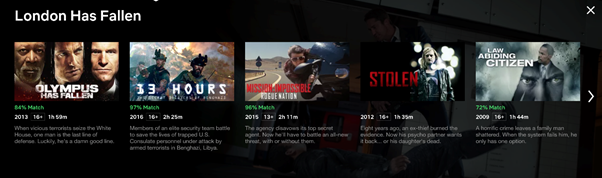


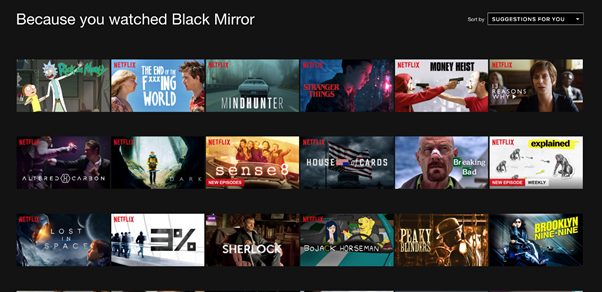


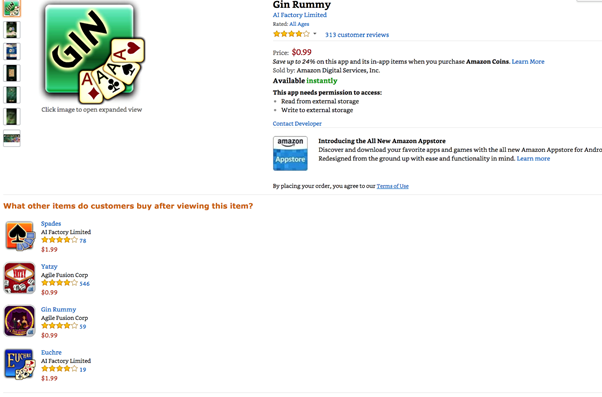


In [1]:
###Install requirements
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from gensim.scripts.glove2word2vec import glove2word2vec
import os

C:\Users\Bhagu\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


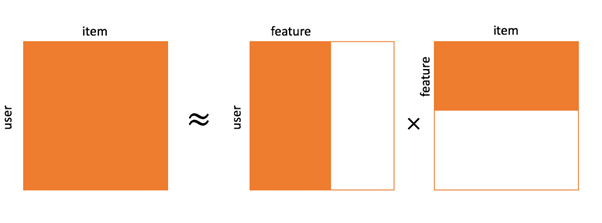


In [2]:
## Load the data
data = pd.read_csv('sample-data.csv')

In [3]:
import string
import re

def clean(Text):
    Text = re.sub('-',' ',Text)
    Text = re.sub('>','> ',Text)
    Text = re.sub('<',' <',Text)
    Text = "".join([ch for ch in Text if ch not in string.punctuation])
    cleanr = re.compile('<.*>')
    cleantext = re.sub(cleanr, ' ', Text)
    cleantext = re.sub(' +',' ',cleantext)
    return cleantext


In [4]:
## very little cleaning
data_clean = data.copy()
data_clean['description'] = data_clean['description'].str.lower()
data_clean['description'] = data_clean['description'].apply(clean)

# APPROACH 1:
## We first try the statistical NLP approach by calculating the tf-idf based features for the dataset
## and then use the cosine similarity function to calculate the list of most similar products to a given input

In [5]:
## Create a TF-IDF matrix of unigrams, bigrams, and trigrams for each product. The 'stop_words' param
## tells the TF-IDF module to ignore common english words like 'the', etc.

tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(data_clean['description'])

In [6]:
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

In [7]:
cosine_similarities.shape

(500, 500)

In [36]:
def get_similarity_m(product_id,cosine_similarities,data_clean,number_similar_products =10,show_simlar = 2):
    similar_products = cosine_similarities[product_id-1].argsort()[:-number_similar_products:-1]
    similar_products = similar_products[1:,]
    print('Description of Product:')
    print(data["description"][product_id-1])
    print('\n')
    print("Similar product to {0} : ".format(product_id))
    for x in similar_products:
        print(x+1)
    print('\n')
    print('Description of Most Similar Product:')
    print(data["description"][similar_products[0]])
    print('\n')
    print(data["description"][similar_products[1]])

In [37]:
get_similarity_m(9,cosine_similarities,data)

Description of Product:
Baby micro d-luxe cardigan - Micro D-Luxe is a heavenly soft fabric with down-to-earth applications. This cardigan is made from a quick-drying, durable 4.6-oz 100% polyester (87% recycled) microdenier fleece that is lightweight and breathable so it can work as a top or midlayer. A wind flap backs the zip front, while the hood has covered-elastic side trim to bundle babies in deep warmth. With slash-style patch pockets, color-coordinating elbow patches and soft self-fabric cuffs. Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Soft, microdenier fleece made from 87% recycled polyester is durable and quick-to-dry"</li> <li>Hood stays secure with covered side elastic</li> <li>Inside neck tape for a clean finish</li> <li>Handwarmer patch pockets</li> <li>"Full front zip backed by a wind flap; soft, self-fabric cuffs"</li></ul><br><br><b>Fabric: </b>4.6-oz 100% microdenier polyester (87% recycled) fleece. Recyclable through the

# APPROACH 2:
## We use word 2 vec to get the paragraph vector of the data
## and then use the cosine similarity function to calculate the list of most similar products to a given input

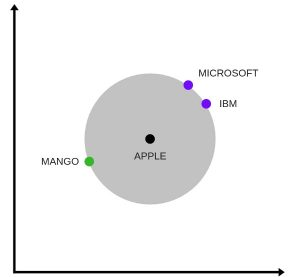

In [10]:
import gensim

In [38]:
tf_idf = TfidfVectorizer(stop_words='english')
vectorizer = tf_idf.fit(data_clean['description'])
result = vectorizer.transform(data_clean['description'])
#print(result)

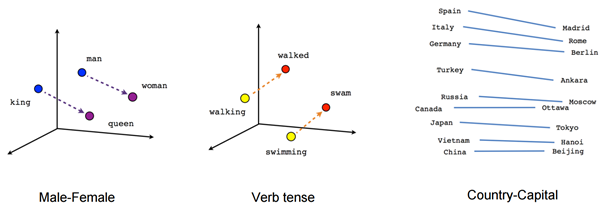


In [12]:
names = vectorizer.get_feature_names()
result = np.array(result.todense())

In [13]:
## create dictionary with having tf-idf more than 0.1 and 

tf_idf_words = []
for r in result:
    dict_word = {}
    non_zero = np.where(r != 0)[0]
    for word in non_zero:
        if r[word] > 0.1:
            dict_word[names[word]] = r[word]
    tf_idf_words.append(dict_word)

In [14]:
data_clean['tf_idf_desc'] = tf_idf_words

In [16]:
### Install the Google word to vector #####
#os.system('''curl https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz -o GoogleNews-vectors-negative300.bin.gz && sudo gunzip GoogleNews-vectors-negative300.bin.gz ''')

In [15]:
##### load the available Google vectors ######
model = gensim.models.KeyedVectors\
        .load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [16]:
########  create the new word2vec #######

def w2v_vectorize_desc(x):
    coeff = 0
    vector = np.zeros(300)
    for word in x:
        if word in model:
            coeff = coeff + x[word]
            vector = vector + model[word] * x[word]
    if coeff != 0:
        vector = vector / coeff 
    return list(vector)

In [17]:
###### apply the transformation #########
data_clean['tf_idf_desc'] = data_clean\
            .apply(lambda x: w2v_vectorize_desc(x['tf_idf_desc']), axis=1)

In [18]:
data_w2v = data_clean[['id','tf_idf_desc']]

In [19]:
products = data_w2v.id.values
vectors = data_clean.tf_idf_desc.values

file = open("product_glove", "w")
for p, v in zip(products, vectors):
    vector_s = " ".join(map(str, v))
    file.write(str(p) + " " + vector_s + '\n')
file.close()


In [20]:
####### product_w2v  using gensim ###########
glove2word2vec("product_glove", "product_w2v")

(500, 300)

In [21]:
##### load the model ##########
product2vec = gensim.models.KeyedVectors.load_word2vec_format("product_w2v")

In [32]:
def get_similarity_w2v(product_id,product2vec,data_clean,number_similar_products =10,show_simlar = 2):
    similar_products = pd.DataFrame(product2vec.most_similar(str(product_id), topn = number_similar_products),columns= ['product_id','score'] )
    print('Description of Product:')
    print(data["description"][product_id-1])
    print('\n')
    print("Similar product to {0} : ".format(product_id))
    for x in range(0,10):
        print(similar_products.iloc[int(x),0])
    print('\n')
    print('Description of Most Similar Product:')
    print([data.loc[int(similar_products.iloc[1,0])-1,"description"]])
    print('\n')
    print([data.loc[int(similar_products.iloc[2,0])-1,"description"]])    
    

In [33]:
get_similarity_w2v(45,product2vec,data_clean)

Description of Product:
Girl's boardie capris - Built for two-week camping trips on Baja beaches, these capris are made of a lightweight, soft-brushed 3.7-oz 100% microfiber polyester that handles salt water, sand and dirt, dry quickly, and have a DWR (durable water repellent) finish. Two back darts and a built-in elastic waist adjustment hone the fit. Three-snap leg openings allow vented styling. With a hook-and-loop soft-tie fly and a self-draining back patch pocket. Hip-riding. Inseam is 18". Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Lightweight, soft-brushed microfiber polyester dries quickly and has a Deluge DWR (durable water repellent) finish"</li> <li>Two back darts and a built-in elastic waist adjustment hone the fit</li> <li>3-snap leg openings allow vented styling</li> <li>"Hook-and-loop, soft-tie fly and self-draining back patch pocket"</li> <li>Hip-riding</li> <li>"Inseam is 18"""</li></ul><br><br><b>Fabric: </b>3.7-oz 100% mi